# SSD300 Training 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2
import tensorflow as tf

sess = tf.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9183788789394145824
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9780369166929173502
physical_device_desc: "device: XLA_CPU device"
]


In [2]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_mobilenet
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [3]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## 2. Build or load the model

You will want to execute either of the two code cells in the subsequent two sub-sections, not both.

In [4]:

import numpy as np
from keras.models import Model
from keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Reshape, Concatenate
from keras.regularizers import l2
import keras.backend as K


import keras.backend as K
from keras.layers import Activation
from keras.layers import Conv2D,SeparableConv2D
from keras.layers import Dropout,BatchNormalization
from keras.layers import AlphaDropout,GaussianDropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Activation
from keras.layers.merge import concatenate
from keras.layers import Reshape
from keras.models import Model
from keras.models import Sequential
from keras.applications import MobileNet

from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_L2Normalization import L2Normalization

In [5]:

def ssd_mobilenet(image_size,
            n_classes,
            l2_regularization=0.0005,
            min_scale=None,
            max_scale=None,
            scales=None,
            aspect_ratios_global=None,
            aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                     [1.0, 2.0, 0.5],
                                     [1.0, 2.0, 0.5]],
            two_boxes_for_ar1=True,
            steps=[8, 16, 32, 64, 100, 300],
            offsets=None,clip_boxes=False,
            
            variances=[0.1, 0.1, 0.2, 0.2],
            coords='centroids',
            normalize_coords=True,
            subtract_mean=[123, 117, 104],
            divide_by_stddev=None,
            swap_channels=[2, 1, 0],
            confidence_thresh=0.01,
            iou_threshold=0.45,
            top_k=200,
            nms_max_output_size=400,
            return_predictor_sizes=False):
   

    n_predictor_layers = 6 # The number of predictor conv layers in the network is 6 for the original SSD300

    n_classes += 1 # Account for the background class.

    # Get a few exceptions out of the way first
    
    if len(variances) != 4:
        raise ValueError("4 variance values must be pased, but {} values were received.".format(len(variances)))
    variances = np.array(variances)
    
    # Set the aspect ratios for each predictor layer. These are only needed for the anchor box layers.
    if aspect_ratios_per_layer:
        aspect_ratios = aspect_ratios_per_layer
    else:
        aspect_ratios = [aspect_ratios_global] * n_predictor_layers

    # Compute the number of boxes to be predicted per cell for each predictor layer.
    # We need this so that we know how many channels the predictor layers need to have.
    if aspect_ratios_per_layer:
        n_boxes = []
        for ar in aspect_ratios_per_layer:
            if (1 in ar) & two_boxes_for_ar1:
                n_boxes.append(len(ar) + 1) # +1 for the second box for aspect ratio 1
            else:
                n_boxes.append(len(ar))
    else: # If only a global aspect ratio list was passed, then the number of boxes is the same for each predictor layer
        if (1 in aspect_ratios_global) & two_boxes_for_ar1:
            n_boxes = len(aspect_ratios_global) + 1
        else:
            n_boxes = len(aspect_ratios_global)
        n_boxes = [n_boxes] * n_predictor_layers

    if steps is None:
        steps = [None] * n_predictor_layers
    if offsets is None:
        offsets = [None] * n_predictor_layers

    l2_reg = l2_regularization
    input_shape=(300,300,300)
    img_size=(input_shape[1],input_shape[0])
    img_height= img_width = input_shape[1]
    img_channels = input_shape[2]
    input_shape=(input_shape[1],input_shape[0],3)
    mobilenet_input_shape=(224,224,3)

    inputs = Input(input_shape)
    x1 = Lambda(lambda z: z,
                output_shape=(img_height, img_width, img_channels),
                name='idendity_layer')(inputs)
    if not (subtract_mean is None):
        x1 = Lambda(lambda z: z - np.array(subtract_mean),
                   output_shape=(img_height, img_width, img_channels),
                   name='input_mean_normalization')(x1)
    if not (divide_by_stddev is None):
        x1 = Lambda(lambda z: z / np.array(divide_by_stddev),
                   output_shape=(img_height, img_width, img_channels),
                   name='input_stddev_normalization')(x1)
    if swap_channels and (img_channels == 3):
        x1 = Lambda(lambda z: z[...,::-1],
                   output_shape=(img_height, img_width, img_channels),
                   name='input_channel_swap')(x1)

    mobilenet=MobileNet(input_shape=mobilenet_input_shape,include_top=False,weights='imagenet')
    FeatureExtractor=Model(inputs=mobilenet.input, outputs=mobilenet.get_layer('conv_dw_11_relu').output)
    mobilenet_conv_dw_11_relu= FeatureExtractor(x1)

    conv11 = Conv2D(512, (1, 1), activation='relu', padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg), name='conv11')(mobilenet_conv_dw_11_relu)
    conv11 = BatchNormalization( momentum=0.99, name='bn11')(conv11)
    conv11 = Activation('relu')(conv11)

    # Block
    #(19,19)
    conv12dw = SeparableConv2D(512, (3, 3),strides=(2, 2), activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg), padding='same', name='conv12dw')(conv11)
    conv12dw = BatchNormalization( momentum=0.99, name='bn12dw')(conv12dw)
    conv12dw = Activation('relu')(conv12dw)
    conv12 = Conv2D(1024, (1, 1), padding='same',activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg),name='conv12')(conv12dw)
    conv12 = BatchNormalization( momentum=0.99, name='bn12')(conv12)

    conv13dw = SeparableConv2D(1024, (3, 3), padding='same',activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg),name='conv13dw')(conv12)
    conv13dw = BatchNormalization( momentum=0.99, name='bn13dw')(conv13dw)
    conv13dw = Activation('relu')(conv13dw)
    
    conv13 = Conv2D(1024, (1, 1),activation='relu', padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg),name='conv13')(conv13dw)
    conv13 = BatchNormalization( momentum=0.99, name='bn13')(conv13)
    conv13 = Activation('relu')(conv13)
    
    conv14_1 = Conv2D(256, (1, 1),activation='relu', padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg), name='conv14_1')(conv13)
    conv14_1 = BatchNormalization( momentum=0.99, name='bn14_1')(conv14_1)
    conv14_1 = Activation('relu')(conv14_1)
    
    conv14_2 = Conv2D(512, (3, 3), strides=(2, 2),activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg),  padding='same', name='conv14_2')(conv14_1)
    conv14_2 = BatchNormalization( momentum=0.99, name='bn14_2')(conv14_2)
    conv14_2 = Activation('relu')(conv14_2)
    
    
    conv15_1 = Conv2D(128, (1, 1), padding='same',activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg),name='conv15_1')(conv14_2)
    conv15_1 = BatchNormalization( momentum=0.99, name='bn15_1')(conv15_1)
    conv15_1 = Activation('relu')(conv15_1)
    
    conv15_2 = Conv2D(256, (3, 3), strides=(2, 2), padding='same',activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg),name='conv15_2')(conv15_1)
    conv15_2 = BatchNormalization( momentum=0.99, name='bn15_2')(conv15_2)
    conv15_2 = Activation('relu')(conv15_2)
    
    conv16_1 = Conv2D(128, (1, 1),  padding='same',activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg), name='conv16_1')(conv15_2)
    conv16_1 = BatchNormalization( momentum=0.99, name='bn16_1')(conv16_1)
    conv16_1 = Activation('relu')(conv16_1)
    
    conv16_2 = Conv2D(256, (3, 3), strides=(2, 2),  padding='same',activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg), name='conv16_2')(conv16_1)
    conv16_2 = BatchNormalization( momentum=0.99, name='bn16_2')(conv16_2)
    conv16_2=Activation('relu')(conv16_2)
    
    conv17_1 = Conv2D(64, (1, 1),  activation='relu', padding='same',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg), name='conv17_1')(conv16_2)
    conv17_1 = BatchNormalization( momentum=0.99, name='bn17_1')(conv17_1)
    conv17_1 = Activation('relu')(conv17_1)
    
    conv17_2 = Conv2D(128, (3, 3), strides=(2, 2), activation='relu',kernel_initializer='he_normal',kernel_regularizer=l2(l2_reg), padding='same', name='conv17_2')(conv17_1)
    conv17_2 = BatchNormalization( momentum=0.99, name='bn17_2')(conv17_2)
    conv17_2 = Activation('relu')(conv17_2)

    conv11_mbox_loc=Conv2D(n_boxes[0] * 4, (1,1),kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), padding='same',name='conv11_mbox_loc')(conv11)
    conv13_mbox_loc=Conv2D(n_boxes[1] * 4, (1,1),kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), padding='same',name='conv13_mbox_loc')(conv13)
    conv14_2_mbox_loc=Conv2D(n_boxes[2] * 4, (1,1),kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), padding='same',name='conv14_2_mbox_loc')(conv14_2)
    conv15_2_mbox_loc=Conv2D(n_boxes[3] * 4, (1,1),kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), padding='same',name='conv15_2_mbox_loc')(conv15_2)
    conv16_2_mbox_loc=Conv2D(n_boxes[4] * 4, (1,1),kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), padding='same',name='conv16_2_mbox_loc')(conv16_2)
    conv17_2_mbox_loc=Conv2D(n_boxes[5] * 4, (1,1),kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), padding='same',name='conv17_2_mbox_loc')(conv17_2)

    conv11_mbox_loc_reshape = Reshape((-1, 4), name='conv11_norm_mbox_loc_reshape')(conv11_mbox_loc)
    conv13_mbox_loc_reshape = Reshape((-1, 4), name='conv13_mbox_loc_reshape')(conv13_mbox_loc)
    conv14_2_mbox_loc_reshape = Reshape((-1, 4), name='conv14_2_mbox_loc_reshape')(conv14_2_mbox_loc)
    conv15_2_mbox_loc_reshape = Reshape((-1, 4), name='conv15_2_mbox_loc_reshape')(conv15_2_mbox_loc)
    conv16_2_mbox_loc_reshape = Reshape((-1, 4), name='conv16_2_mbox_loc_reshape')(conv16_2_mbox_loc)
    conv17_2_mbox_loc_reshape = Reshape((-1, 4), name='conv17_2_mbox_loc_reshape')(conv17_2_mbox_loc)

    mbox_loc = Concatenate(axis=1, name='mbox_loc')([conv11_mbox_loc_reshape,
                                                 conv13_mbox_loc_reshape,
                                                 conv14_2_mbox_loc_reshape,
                                                 conv15_2_mbox_loc_reshape,
                                                 conv16_2_mbox_loc_reshape,
                                                 conv17_2_mbox_loc_reshape ])

    conv11_mbox_conf = Conv2D(n_boxes[0] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv11_mbox_conf')(conv11)
    conv13_mbox_conf = Conv2D(n_boxes[1] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv13_mbox_conf')(conv13)
    conv14_2_mbox_conf = Conv2D(n_boxes[2] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv14_2_mbox_conf')(conv14_2)
    conv15_2_mbox_conf = Conv2D(n_boxes[3] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv15_2_mbox_conf')(conv15_2)
    conv16_2_mbox_conf = Conv2D(n_boxes[4] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv16_2_mbox_conf')(conv16_2)
    conv17_2_mbox_conf = Conv2D(n_boxes[5] * n_classes, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(l2_reg), name='conv17_2_mbox_conf')(conv17_2)


    conv11_mbox_conf_reshape = Reshape((-1, n_classes), name='conv11_mbox_conf_reshape')(conv11_mbox_conf)
    conv13_mbox_conf_reshape = Reshape((-1, n_classes), name='conv13_mbox_conf_reshape')(conv13_mbox_conf)
    conv14_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv14_2_mbox_conf_reshape')(conv14_2_mbox_conf)
    conv15_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv15_2_mbox_conf_reshape')(conv15_2_mbox_conf)
    conv16_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv16_2_mbox_conf_reshape')(conv16_2_mbox_conf)
    conv17_2_mbox_conf_reshape = Reshape((-1, n_classes), name='conv17_2_mbox_conf_reshape')(conv17_2_mbox_conf)






    # Output shape of `mbox_conf`: (batch, n_boxes_total, n_classes)
    mbox_conf = Concatenate(axis=1, name='mbox_conf')([conv11_mbox_conf_reshape,
                                                       conv13_mbox_conf_reshape,
                                                       conv14_2_mbox_conf_reshape,
                                                       conv15_2_mbox_conf_reshape,
                                                       conv16_2_mbox_conf_reshape,
                                                       conv17_2_mbox_conf_reshape])



    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)



    conv11_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[0], next_scale=scales[1], aspect_ratios=aspect_ratios[0],
                                         two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[0], this_offsets=offsets[0],
                                         variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv11_mbox_priorbox')(conv11_mbox_loc)
    conv13_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[1], next_scale=scales[2], aspect_ratios=aspect_ratios[1],
                                    two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[1], this_offsets=offsets[1],
                                    variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv13_mbox_priorbox')(conv13_mbox_loc)
    conv14_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[2], next_scale=scales[3], aspect_ratios=aspect_ratios[2],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[2], this_offsets=offsets[2],
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv14_2_mbox_priorbox')(conv14_2_mbox_loc)
    conv15_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[3], next_scale=scales[4], aspect_ratios=aspect_ratios[3],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[3], this_offsets=offsets[3],
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv15_2_mbox_priorbox')(conv15_2)
    conv16_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[4], next_scale=scales[5], aspect_ratios=aspect_ratios[4],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[4], this_offsets=offsets[4], 
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv16_2_mbox_priorbox')(conv16_2_mbox_loc)
    conv17_2_mbox_priorbox = AnchorBoxes(img_height, img_width, this_scale=scales[5], next_scale=scales[6], aspect_ratios=aspect_ratios[5],
                                        two_boxes_for_ar1=two_boxes_for_ar1, this_steps=steps[5], this_offsets=offsets[5], 
                                        variances=variances, coords=coords, normalize_coords=normalize_coords, name='conv17_2_mbox_priorbox')(conv17_2_mbox_loc)
    # Reshape the anchor box tensors, yielding 3D tensors of shape `(batch, height * width * n_boxes, 8)`
    conv11_mbox_priorbox_reshape = Reshape((-1, 8), name='conv11_mbox_priorbox_reshape')(conv11_mbox_priorbox)
    conv13_mbox_priorbox_reshape = Reshape((-1, 8), name='conv13_mbox_priorbox_reshape')(conv13_mbox_priorbox)
    conv14_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv14_2_mbox_priorbox_reshape')(conv14_2_mbox_priorbox)
    conv15_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv15_2_mbox_priorbox_reshape')(conv15_2_mbox_priorbox)
    conv16_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv16_2_mbox_priorbox_reshape')(conv16_2_mbox_priorbox)
    conv17_2_mbox_priorbox_reshape = Reshape((-1, 8), name='conv17_2_mbox_priorbox_reshape')(conv17_2_mbox_priorbox)


    # Output shape of `mbox_priorbox`: (batch, n_boxes_total, 8)
    mbox_priorbox = Concatenate(axis=1, name='mbox_priorbox')([conv11_mbox_priorbox_reshape,
                                                               conv13_mbox_priorbox_reshape,
                                                               conv14_2_mbox_priorbox_reshape,
                                                               conv15_2_mbox_priorbox_reshape,
                                                               conv16_2_mbox_priorbox_reshape,
                                                               conv17_2_mbox_priorbox_reshape])


    predictions = concatenate(axis=2, name='predictions',inputs=[mbox_conf_softmax, mbox_loc, mbox_priorbox])
    model=Model(inputs=inputs, outputs=predictions)
    if return_predictor_sizes:
        predictor_sizes = np.array([conv11_mbox_conf._keras_shape[1:3],
                                     conv13_mbox_conf._keras_shape[1:3],
                                     conv14_2_mbox_conf._keras_shape[1:3],
                                     conv15_2_mbox_conf._keras_shape[1:3],
                                     conv16_2_mbox_conf._keras_shape[1:3],
                                     conv17_2_mbox_conf._keras_shape[1:3]])
        return model, predictor_sizes
    else:
        return model

In [6]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_mobilenet(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
               
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = './VGG_ILSVRC_16_layers_fc_reduced.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)

W0808 23:47:13.816847 140130690369280 deprecation_wrapper.py:119] From /home/purva/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0808 23:47:13.817805 140130690369280 deprecation_wrapper.py:119] From /home/purva/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0808 23:47:13.827225 140130690369280 deprecation_wrapper.py:119] From /home/purva/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 23:47:13.828164 140130690369280 deprecation_wrapper.py:119] From /home/purva/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please

### 2.2 Load a previously created model



In [26]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = './ssd300.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

## 3. Set up the data generators for the training



In [7]:

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)


VOC_2007_images_dir      = './VOCdevkit/VOC2007/JPEGImages/'
VOC_2012_images_dir      = './VOCdevkit/VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = './VOCdevkit/VOC2007/Annotations/'
VOC_2012_annotations_dir      = './VOCdevkit/VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = './VOCdevkit/VOC2007/ImageSets/Main/train.txt'
VOC_2012_train_image_set_filename    = './VOCdevkit/VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = './VOCdevkit/VOC2007/ImageSets/Main/val.txt'
VOC_2012_val_image_set_filename      = './VOCdevkit/VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = './VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
VOC_2012_trainval_image_set_filename = './VOCdevkit/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = './VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                     VOC_2012_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                             VOC_2012_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir,
                                          VOC_2012_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)


train_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07+12_trainval.h5',
                                  resize=False,
                                  variable_image_size=True,
                                  verbose=True)

val_dataset.create_hdf5_dataset(file_path='dataset_pascal_voc_07_test.h5',
                                resize=False,
                                variable_image_size=True,
                                verbose=True)

Creating HDF5 dataset: 100%|██████████| 4952/4952 [00:24<00:00, 199.20it/s]


In [9]:
# 3: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv11_mbox_conf').output_shape[1:3],
                   model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv14_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv15_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv16_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv17_2_mbox_conf').output_shape[1:3]]
ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	 16551
Number of images in the validation dataset:	  4952


## 4. Set the remaining training parameters

We've already chosen an optimizer and set the batch size above, now let's set the remaining training parameters. I'll set one epoch to consist of 1,000 training steps. The next code cell defines a learning rate schedule that replicates the learning rate schedule of the original Caffe implementation for the training of the SSD300 Pascal VOC "07+12" model. That model was trained for 120,000 steps with a learning rate of 0.001 for the first 80,000 steps, 0.0001 for the next 20,000 steps, and 0.00001 for the last 20,000 steps. If you're training on a different dataset, define the learning rate schedule however you see fit.

I'll set only a few essential Keras callbacks below, feel free to add more callbacks if you want TensorBoard summaries or whatever. We obviously need the learning rate scheduler and we want to save the best models during the training. It also makes sense to continuously stream our training history to a CSV log file after every epoch, because if we didn't do that, in case the training terminates with an exception at some point or if the kernel of this Jupyter notebook dies for some reason or anything like that happens, we would lose the entire history for the trained epochs. Finally, we'll also add a callback that makes sure that the training terminates if the loss becomes `NaN`. Depending on the optimizer you use, it can happen that the loss becomes `NaN` during the first iterations of the training. In later iterations it's less of a risk. For example, I've never seen a `NaN` loss when I trained SSD using an Adam optimizer, but I've seen a `NaN` loss a couple of times during the very first couple of hundred training steps of training a new model when I used an SGD optimizer.

In [10]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch <= 100: return 0.001
    else: return 0.0001

In [11]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='ssd300_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_pascal_07+12_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]

## 5. Train

In [11]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 0
final_epoch     = 10
steps_per_epoch = 518

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 354s 683ms/step - loss: 16.1470 - val_loss: 17.0346

Epoch 00001: val_loss improved from inf to 17.03465, saving model to ssd300_pascal_07+12_epoch-01_loss-16.1446_val_loss-17.0346.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 350s 676ms/step - loss: 13.5909 - val_loss: 12.8809

Epoch 00002: val_loss improved from 17.03465 to 12.88088, saving model to ssd300_pascal_07+12_epoch-02_loss-13.5900_val_loss-12.8809.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 337s 651ms/step - loss: 13.0950 - val_loss: 12.3822

Epoch 00003: val_loss improved from 12.88088 to 12.38217, saving model to ssd300_pascal_07+12_epoch-03_loss-13.0872_val_loss-12.3822.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 

In [12]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 10
final_epoch     = 30
steps_per_epoch = 518

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 11/30

Epoch 00011: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 359s 693ms/step - loss: 11.3785 - val_loss: 10.8483

Epoch 00011: val_loss improved from 10.97414 to 10.84826, saving model to ssd300_pascal_07+12_epoch-11_loss-11.3800_val_loss-10.8483.h5
Epoch 12/30

Epoch 00012: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 349s 673ms/step - loss: 11.2464 - val_loss: 10.6956

Epoch 00012: val_loss improved from 10.84826 to 10.69558, saving model to ssd300_pascal_07+12_epoch-12_loss-11.2445_val_loss-10.6956.h5
Epoch 13/30

Epoch 00013: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 348s 672ms/step - loss: 11.1254 - val_loss: 10.7392

Epoch 00013: val_loss did not improve from 10.69558
Epoch 14/30

Epoch 00014: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 339s 654ms/step - loss: 1

In [13]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 30
final_epoch     = 90
steps_per_epoch = 518

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 31/90

Epoch 00031: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 355s 685ms/step - loss: 9.5584 - val_loss: 8.9532

Epoch 00031: val_loss improved from 9.08511 to 8.95321, saving model to ssd300_pascal_07+12_epoch-31_loss-9.5594_val_loss-8.9532.h5
Epoch 32/90

Epoch 00032: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 349s 674ms/step - loss: 9.4700 - val_loss: 8.9703

Epoch 00032: val_loss did not improve from 8.95321
Epoch 33/90

Epoch 00033: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 341s 659ms/step - loss: 9.3674 - val_loss: 8.8913

Epoch 00033: val_loss improved from 8.95321 to 8.89129, saving model to ssd300_pascal_07+12_epoch-33_loss-9.3664_val_loss-8.8913.h5
Epoch 34/90

Epoch 00034: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 354s 683ms/step - loss: 9.3658 - val_los

Epoch 59/90

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 349s 674ms/step - loss: 8.0598 - val_loss: 7.6016

Epoch 00059: val_loss improved from 7.64411 to 7.60161, saving model to ssd300_pascal_07+12_epoch-59_loss-8.0588_val_loss-7.6016.h5
Epoch 60/90

Epoch 00060: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 343s 661ms/step - loss: 7.9994 - val_loss: 7.5432

Epoch 00060: val_loss improved from 7.60161 to 7.54324, saving model to ssd300_pascal_07+12_epoch-60_loss-7.9962_val_loss-7.5432.h5
Epoch 61/90

Epoch 00061: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 339s 655ms/step - loss: 7.9544 - val_loss: 7.4907

Epoch 00061: val_loss improved from 7.54324 to 7.49066, saving model to ssd300_pascal_07+12_epoch-61_loss-7.9526_val_loss-7.4907.h5
Epoch 62/90

Epoch 00062: LearningRateScheduler setting learning rate to 0.001.
51

Epoch 87/90

Epoch 00087: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 342s 660ms/step - loss: 7.0746 - val_loss: 6.6915

Epoch 00087: val_loss improved from 6.69815 to 6.69154, saving model to ssd300_pascal_07+12_epoch-87_loss-7.0694_val_loss-6.6915.h5
Epoch 88/90

Epoch 00088: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 337s 650ms/step - loss: 7.0416 - val_loss: 6.6027

Epoch 00088: val_loss improved from 6.69154 to 6.60269, saving model to ssd300_pascal_07+12_epoch-88_loss-7.0434_val_loss-6.6027.h5
Epoch 89/90

Epoch 00089: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 338s 653ms/step - loss: 7.0170 - val_loss: 6.6012

Epoch 00089: val_loss improved from 6.60269 to 6.60118, saving model to ssd300_pascal_07+12_epoch-89_loss-7.0082_val_loss-6.6012.h5
Epoch 90/90

Epoch 00090: LearningRateScheduler setting learning rate to 0.001.
51

In [15]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 90
final_epoch     = 120
steps_per_epoch = 518

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 91/120

Epoch 00091: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 356s 686ms/step - loss: 6.9483 - val_loss: 6.5386

Epoch 00091: val_loss improved from 6.56507 to 6.53859, saving model to ssd300_pascal_07+12_epoch-91_loss-6.9445_val_loss-6.5386.h5
Epoch 92/120

Epoch 00092: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 338s 652ms/step - loss: 6.8937 - val_loss: 6.5427

Epoch 00092: val_loss did not improve from 6.53859
Epoch 93/120

Epoch 00093: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 335s 647ms/step - loss: 6.8501 - val_loss: 6.4620

Epoch 00093: val_loss improved from 6.53859 to 6.46200, saving model to ssd300_pascal_07+12_epoch-93_loss-6.8503_val_loss-6.4620.h5
Epoch 94/120

Epoch 00094: LearningRateScheduler setting learning rate to 0.001.
518/518 [==============================] - 337s 651ms/step - loss: 6.8812 - val

In [13]:
# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch   = 120
final_epoch     = 130
steps_per_epoch = 518

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Epoch 121/130

Epoch 00121: LearningRateScheduler setting learning rate to 0.0001.
120/518 [=====>........................] - ETA: 32:25 - loss: 6.4574

KeyboardInterrupt: 

In [14]:
model_name = 'ssd300'
model.save('{}.h5'.format(model_name))
model.save_weights('{}_weights.h5'.format(model_name))

print()
print("Model saved under {}.h5".format(model_name))
print("Weights also saved separately under {}_weights.h5".format(model_name))
print()


Model saved under ssd300.h5
Weights also saved separately under ssd300_weights.h5



## 6. Make predictions


In [27]:
# 1: Set the generator for the predictions.

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [28]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: ./VOCdevkit/VOC2007/JPEGImages/004440.jpg

Ground truth boxes:

[[ 15  87   4 461 375]]


In [29]:
# 3: Make predictions.

y_pred = model.predict(batch_images)

In [30]:
# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [31]:
# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 15.     0.9  199.   104.   598.   460.  ]
 [ 15.     0.76  52.     4.   476.   371.  ]]


Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

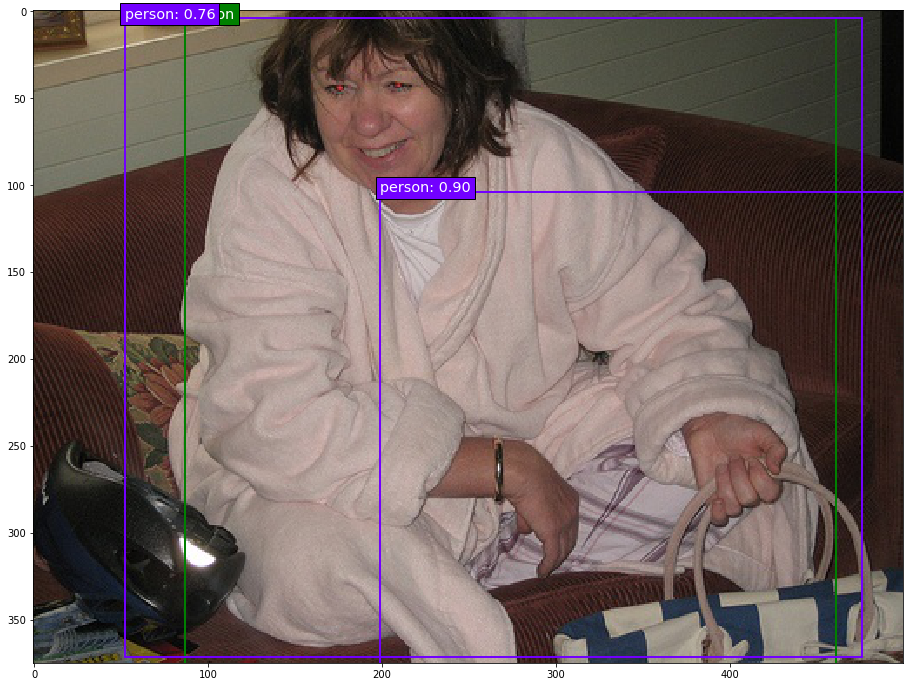

In [32]:
# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [33]:
pwd

'/home/purva/Desktop/purva/mobilenet'

In [34]:
import pandas as pd
val_dataset_size

4952

In [35]:
for j in range(val_dataset_size):
    
    #batch_X, batch_image_ids,batch_filenames, batch_inverse_coord_transform, batch_original_images, batch_original_labels = next(generator)
    batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

    y_pred = model.predict(batch_images)
    y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)


    y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)


    df=pd.DataFrame((y_pred_decoded_inv)[0])
    df=df.round(2)

    for i in range(len(df)):
        df[0][i]=classes[int(df[0][i])]
    df.to_csv('{}'.format(batch_filenames[0].split("/")[-1].replace("jpg","txt")), header=None, index=None, sep=' ', mode='a')

/home/purva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
